In [39]:
import json
from google.colab import userdata

# Retrieve the Kaggle API key from Colab secrets
kaggle_api_key = userdata.get('KAGGLE_JSON')

# Create the .kaggle directory and write the key
!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(kaggle_api_key)

# Set the file permissions for security
!chmod 600 /root/.kaggle/kaggle.json

In [40]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("darshanthakare/dog-breeds-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-breeds-image-dataset


In [41]:
# PyTorch and Torchvision libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
import glob

import torchvision
from torchvision import datasets, models, transforms

# For visualization and file system operations
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np

In [42]:
# Keep device as 'cpu' by default, model will be moved to cuda only during training/validation
device="cpu"
# device="cuda" if torch.cuda.is_available() else 'cpu' # Commented out the original line
print(f"Using device: {device}")

Using device: cpu


In [43]:
try:
    shutil.rmtree('./data')
    print("Deleted the old 'data' directory.")
except FileNotFoundError:
    print("The 'data' directory does not exist, proceeding with a clean start.")
    pass

Deleted the old 'data' directory.


## 1> Data Splitting (80% for training, 20% for validation)

In [44]:
import os
import shutil
import glob
import random

# 1: Clean up and then split the dataset into training and validation sets
# Define the base path to your downloaded dataset
# Corrected path based on Kagglehub download location
data_dir = '/kaggle/input/dog-breeds-image-dataset' # Corrected path based on previous cell output
images_dir = os.path.join(data_dir, 'Dog Breeds Image Dataset') # Assuming this subdirectory exists within the downloaded content

# Create new directories for the train and validation splits
base_output_dir = './data'
train_dir = os.path.join(base_output_dir, 'train')
val_dir = os.path.join(base_output_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8

# Define supported image extensions
supported_extensions = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.bmp', '*.pgm', '*.tif', '*.tiff', '*.webp']

# Iterate through each dog breed folder
for breed_folder in os.listdir(images_dir):
    breed_path = os.path.join(images_dir, breed_folder)
    if os.path.isdir(breed_path):
        # Create corresponding breed folders in the new train and val directories
        os.makedirs(os.path.join(train_dir, breed_folder), exist_ok=True)
        os.makedirs(os.path.join(val_dir, breed_folder), exist_ok=True)

        # Get all image files for the current breed using glob for robustness, checking all supported extensions
        all_images = []
        for ext in supported_extensions:
            all_images.extend(glob.glob(os.path.join(breed_path, ext)))

        random.shuffle(all_images)

        # Split images based on the ratio
        num_train = int(len(all_images) * split_ratio)
        num_val = len(all_images) - num_train

        # Handle cases with very few images to ensure at least one in train if possible
        if len(all_images) > 0:
            if num_train == 0 and num_val > 0:
                # If no images for train, but images exist, put at least one in train
                num_train = 1
                num_val = len(all_images) - num_train
            elif num_val == 0 and num_train > 0:
                 # If no images for val, but images exist, put at least one in val
                num_val = 1
                num_train = len(all_images) - num_val
            elif num_train == 0 and num_val == 0:
                 # If no images at all for this breed, skip
                 continue


        train_images = all_images[:num_train]
        val_images = all_images[num_train:]

        # Copy images to the new train and val folders
        for src_path in train_images:
            # Extract just the filename from the full path
            img_filename = os.path.basename(src_path)
            # Create a full destination path
            dst_path = os.path.join(train_dir, breed_folder, img_filename)
            shutil.copy(src_path, dst_path)
        for src_path in val_images:
            # Extract just the filename from the full path
            img_filename = os.path.basename(src_path)
            # Create a full destination path
            dst_path = os.path.join(val_dir, breed_folder, img_filename)
            shutil.copy(src_path, dst_path)

        # Print the number of files copied to each directory for verification
        # num_train_copied = len(os.listdir(os.path.join(train_dir, breed_folder)))
        # num_val_copied = len(os.listdir(os.path.join(val_dir, breed_folder)))


print("Dataset split into train and validation sets successfully!")

Dataset split into train and validation sets successfully!


##2> Define transforms and create datasets & dataloaders

In [45]:
import torchvision.transforms as transforms

# Define the base directory where the split data is located
data_root = './data'

# Define transformations for the training data (with data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define transformations for the validation data (without data augmentation)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Data transformations updated with RandomAffine for training.")

Data transformations updated with RandomAffine for training.


###2.1> Creating datasets using the standard PyTorch ImageFolder

In [46]:
import os
import torchvision.datasets as datasets

# This cell attempts to create datasets using the standard PyTorch ImageFolder.
# However, it soemtimes encounter errors due to issues with ImageFolder handling classes with very few images.

# Define the base directory where the split data is located
data_root = './data'
train_dir_path = os.path.join(data_root, 'train')
val_dir_path = os.path.join(data_root, 'val')

# Define supported image extensions for the custom validation
supported_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

# Custom function to check if a file is a valid image file
def is_valid_image(filepath):
    # Check if the file exists
    if not os.path.exists(filepath):
        return False
    # Check if the file has a supported extension (case-insensitive)
    if not filepath.lower().endswith(supported_extensions):
        return False
    return True


# Create datasets using ImageFolder
train_dataset_attempt = datasets.ImageFolder(
    train_dir_path,
    transform=train_transforms,
    is_valid_file=is_valid_image
)

val_dataset_attempt = datasets.ImageFolder(
    val_dir_path,
    transform=val_transforms,
    allow_empty=True,
    is_valid_file=is_valid_image
)

print("ImageFolder dataset creation attempt finished.")

ImageFolder dataset creation attempt finished.


###2.2> Creating the training and validation datasets and dataloaders using a custom Dataset class

In [47]:
# This cell creates the training and validation datasets and dataloaders using a custom Dataset class.
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
import os
import torch
import torchvision.transforms as transforms # Import transforms

# Define the base directory where the split data is located
data_root = './data'
train_dir_path = os.path.join(data_root, 'train')
val_dir_path = os.path.join(data_root, 'val')

# List of classes that were causing FileNotFoundError and seem to have problematic images with ImageFolder
problematic_classes = ['indian_bakharwal', 'indian_chippiparai', 'indian_gaddi', 'indian_greyhound', 'indian_mastiff', 'indian_mudhol', 'indian_pariah', 'indian_sheepdog', 'indian_spitz', 'kombai', 'sharpei', 'welsh_terrier']

# Define supported image extensions
supported_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

# Manually collect image paths and labels, excluding problematic classes from train
def make_custom_dataset(directory, class_to_idx, exclude_classes=[]):
    instances = []
    directory = os.path.expanduser(directory)
    for target_class in sorted(class_to_idx.keys()):
        if target_class in exclude_classes:
            print(f"Skipping class '{target_class}' in custom dataset creation as it was problematic with ImageFolder.")
            continue

        d = os.path.join(directory, target_class)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if fname.lower().endswith(supported_extensions):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target_class])
                    instances.append(item)
    return instances

# Get class names and map them to indices
classes = sorted(entry.name for entry in os.scandir(train_dir_path) if entry.is_dir())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

# Save the classes list using pickle for later use
try:
    drive_save_dir_for_classes = '/content/drive/MyDrive/Pytorch_project'
    os.makedirs(drive_save_dir_for_classes, exist_ok=True)
    classes_save_path = os.path.join(drive_save_dir_for_classes, 'classes.pkl')
    with open(classes_save_path, 'wb') as f:
        pickle.dump(classes, f)
    print(f"Classes list saved successfully to {classes_save_path}")
except Exception as e:
    print(f"An error occurred while saving the classes list: {e}")


# Create the list of samples for train and validation
train_samples = make_custom_dataset(train_dir_path, class_to_idx, exclude_classes=problematic_classes)
val_samples = make_custom_dataset(val_dir_path, class_to_idx)

# Define a custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, target

# Create the custom datasets
train_dataset = CustomImageDataset(train_samples, transform=train_transforms)
val_dataset = CustomImageDataset(val_samples, transform=val_transforms)

print("Custom Datasets created successfully.")

# Add a check for the number of samples found
print(f"Number of samples found in train_dataset: {len(train_dataset.samples)}")
print(f"Number of samples found in val_dataset: {len(val_dataset.samples)}")

# Create dataloaders to efficiently load and batch the data
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Print a summary of the data setup
print("\nData setup complete (using custom dataset):")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of classes: {len(classes)}")
print(f"Class labels: {classes[:5]}...")

Classes list saved successfully to /content/drive/MyDrive/Pytorch_project/classes.pkl
Skipping class 'indian_bakharwal' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_chippiparai' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_gaddi' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_greyhound' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_mastiff' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_mudhol' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_pariah' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_sheepdog' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'indian_spitz' in custom dataset creation as it was problematic with ImageFolder.
Skipping class 'komb

###Visualize a few images from the training dataset

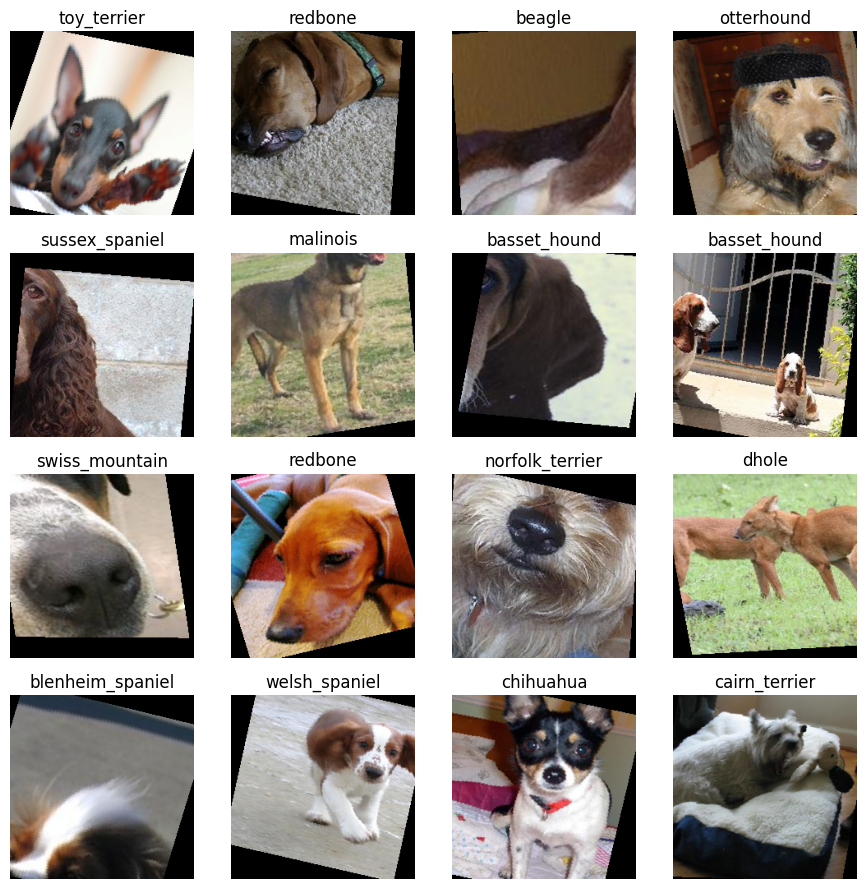

In [48]:
# Visualize a few images from the training dataset
import matplotlib.pyplot as plt
import random
import numpy as np # Import numpy for unnormalization

# Get the list of class names from the created dataset
# Note: The classes are inferred from the directory names when creating the dataset
# class_names = train_dataset.classes # This attribute does not exist in the custom dataset
class_names = classes # Use the globally available 'classes' variable

# Set a seed for reproducibility in visualization
random.seed(42)
torch.manual_seed(42)

# Define unnormalization function (reverse of the normalization applied in transforms)
# These values should match the mean and std used in your transforms
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(tensor):
    """Unnormalize a tensor image."""
    tensor = tensor.permute(1, 2, 0).numpy() # Permute and convert to numpy
    tensor = std * tensor + mean # Unnormalize
    tensor = np.clip(tensor, 0, 1) # Clip values to the valid range [0, 1]
    return tensor

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    # Get a random index
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()

    # Get the image and label from the training dataset
    img, label = train_dataset[random_idx]

    # Add subplot
    fig.add_subplot(rows, cols, i)

    # Display the unnormalized image
    plt.imshow(unnormalize(img))

    # Set the title with the class name
    plt.title(class_names[label])

    # Turn off the axis
    plt.axis(False)

plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()

##3> Model Building (Transfer Learning with ResNet50)

In [49]:
# 3: Define the Model (Transfer Learning with ResNet)
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torch.nn as nn
import os
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch # Import torch

try:
    import torchinfo
except ImportError:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

# Define the base directory where the split data is located
data_root = './data'
train_dir_path = os.path.join(data_root, 'train')

# Get class names and map them to indices
classes = sorted(entry.name for entry in os.scandir(train_dir_path) if entry.is_dir())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}


# Load a pre-trained ResNet50 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Get the number of input features for the final classification layer
num_ftrs = model.fc.in_features

# Get the number of classes in our dataset.
num_classes = len(classes)

# Replace the final fully connected layer (the classifier)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

# Implement gradual unfreezing
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the final fully connected layer (classifier)
for param in model.fc.parameters():
    param.requires_grad = True

# Define the optimizer again to include the trainable parameters and add Weight Decay
LEARNING_RATE = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=0.0001)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
print("Learning rate scheduler defined successfully.")

print("\nModel defined successfully:")
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Learning rate scheduler defined successfully.

Model defined successfully:


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 157]             --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

##4> Loss Function and Optimizer

In [50]:
import torch.nn as nn
import torch.optim as optim

#Define Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

##5> Training and Evaluation Loops

In [51]:
# Create Training and Evaluation Loops
from tqdm.auto import tqdm
import numpy as np
import warnings
import torch
import os
from google.colab import drive # Import drive

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predicted labels (e.g., from y_pred.argmax(dim=1)). # <--- updated this line
                                These are the class predictions to be compared to y_true.

    Returns:
        float: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def mixup_data(x, y, alpha=1.0):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda() if x.is_cuda else torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None,
               use_mixup: bool = False,
               mixup_alpha: float = 1.0):

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        if use_mixup:
            mixed_X, y_a, y_b, lam = mixup_data(X, y, mixup_alpha)
            y_pred = model(mixed_X)
            loss = mixup_criterion(loss_fn, y_pred, y_a, y_b, lam)
        else:
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not use_mixup:
            train_acc += accuracy_fn(y_true=y,
                                     y_pred=y_pred.argmax(dim=1))


    train_loss = train_loss / len(dataloader)
    if use_mixup:
        train_acc = 0
    else:
        train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):

    model.eval()

    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)

            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_acc += accuracy_fn(y_true=y,
                                   y_pred=val_pred_logits.argmax(dim=1))

        val_loss = val_loss / len(dataloader)
        val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          scheduler: torch.optim.lr_scheduler._LRScheduler = None,
          use_mixup: bool = False,
          mixup_alpha: float = 1.0):

    # Mount Google Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Define the directory in Google Drive to save checkpoints
    drive_checkpoint_dir = '/content/drive/MyDrive/Pytorch_project/checkpoints'
    os.makedirs(drive_checkpoint_dir, exist_ok=True)
    print(f"Checkpoints will be saved to: {drive_checkpoint_dir}")


    model.to(device)

    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    best_val_acc = 0.0
    best_epoch = -1
    last_saved_checkpoint_path = None # Keep track of the last saved checkpoint

    # Check for existing checkpoints to resume training
    latest_checkpoint_path = None
    # Iterate through files to find the latest checkpoint
    checkpoint_files = [f for f in os.listdir(drive_checkpoint_dir) if f.startswith("best_model_checkpoint_epoch_") and f.endswith(".pth")]
    if checkpoint_files:
        # Sort files to find the latest one (assuming filenames are sorted by epoch)
        latest_checkpoint_file = sorted(checkpoint_files)[-1]
        latest_checkpoint_path = os.path.join(drive_checkpoint_dir, latest_checkpoint_file)


    if latest_checkpoint_path and os.path.exists(latest_checkpoint_path):
        print(f"Resuming training from checkpoint: {latest_checkpoint_path}")
        checkpoint = torch.load(latest_checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint['best_val_acc']
        last_saved_checkpoint_path = latest_checkpoint_path # Set the last saved checkpoint path
        print(f"Resumed from epoch {start_epoch} with best validation accuracy {best_val_acc:.4f}")
    else:
        start_epoch = 0
        best_val_acc = 0.0
        print("No checkpoint found, starting training from scratch.")


    for epoch in tqdm(range(start_epoch, epochs)): # Start from the resumed epoch


        if epoch == 5:
             print(f"Epoch {epoch+1}: Unfreezing layer4.")
             for name, param in model.named_parameters():
                 if 'layer4' in name:
                     param.requires_grad = True
             optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.0001)
             print(f"Epoch {epoch+1}: Optimizer re-initialized with lower LR for layer4.")

        elif epoch == 10:
             print(f"Epoch {epoch+1}: Unfreezing all layers.")
             for param in model.parameters():
                 param.requires_grad = True
             optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001, weight_decay=0.0001)
             print(f"Epoch {epoch+1}: Optimizer re-initialized with even lower LR for all layers.")

        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device,
                                          scheduler=None,
                                          use_mixup=use_mixup,
                                          mixup_alpha=mixup_alpha)

        val_loss, val_acc = val_step(model=model,
                                        dataloader=val_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        if scheduler:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                scheduler.step()
            print(f"Epoch {epoch+1}: Learning rate stepped to {scheduler.get_last_lr()}")


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Save checkpoint to Google Drive if it's the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            # Define the checkpoint path in Google Drive
            checkpoint_path_drive = os.path.join(drive_checkpoint_dir, f"best_model_checkpoint_epoch_{epoch+1}_acc_{best_val_acc:.4f}.pth")

            # Delete the previous best checkpoint if it exists
            if last_saved_checkpoint_path and os.path.exists(last_saved_checkpoint_path):
                try:
                    os.remove(last_saved_checkpoint_path)
                    print(f"Deleted previous best checkpoint: {last_saved_checkpoint_path}")
                except Exception as e:
                    print(f"Error deleting previous checkpoint: {e}")

            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'loss': loss_fn,
                'best_val_acc': best_val_acc
            }, checkpoint_path_drive)
            print(f"Epoch {epoch+1}: Saved new best model checkpoint to {checkpoint_path_drive} with validation accuracy: {best_val_acc:.4f}")
            last_saved_checkpoint_path = checkpoint_path_drive # Update the last saved checkpoint path

    return results

##6> Train the Model

In [52]:
#Train the Model
import torch
import os
import torch.optim as optim # Import optim
from torch.optim.lr_scheduler import StepLR # Import StepLR
import torchvision.models as models # Import models
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights
import torch.nn as nn # Import nn

NUM_EPOCHS = 25

# Define the base directory where the split data is located
data_root = './data'
train_dir_path = os.path.join(data_root, 'train')

# Get class names and map them to indices
classes = sorted(entry.name for entry in os.scandir(train_dir_path) if entry.is_dir())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

# Get the number of classes in our dataset.
num_classes = len(classes)

# Create the model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Get the number of input features for the final classification layer
num_ftrs = model.fc.in_features

# Replace the final fully connected layer (the classifier)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)


# Define the checkpoint path
checkpoint_path = "best_model_checkpoint.pth" # Use a consistent filename

# Determine start_epoch and best_val_acc based on checkpoint existence
start_epoch = 0
best_val_acc = 0.0
latest_checkpoint_path = None

# Find the latest checkpoint in the drive directory
drive_checkpoint_dir = '/content/drive/MyDrive/Pytorch_project/checkpoints'
if os.path.exists(drive_checkpoint_dir):
    for filename in sorted(os.listdir(drive_checkpoint_dir)):
        if filename.startswith("best_model_checkpoint_epoch_") and filename.endswith(".pth"):
            latest_checkpoint_path = os.path.join(drive_checkpoint_dir, filename)

if latest_checkpoint_path and os.path.exists(latest_checkpoint_path):
    print(f"Found checkpoint: {latest_checkpoint_path}")
    try:
        checkpoint = torch.load(latest_checkpoint_path, map_location='cpu', weights_only=False)
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint['best_val_acc']
        print(f"Resuming from epoch {start_epoch} with best validation accuracy {best_val_acc:.4f}")
    except Exception as e:
        print(f"Error loading checkpoint {latest_checkpoint_path}: {e}")
        print("Starting training from scratch.")
        start_epoch = 0
        best_val_acc = 0.0
else:
    print(f"No checkpoint found, starting training from scratch.")


# Initialize model parameters and optimizer based on start_epoch for gradual unfreezing
if start_epoch < 5:
    current_lr = 0.001
    # Freeze all layers except the final classifier
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    print("Initializing for training with only classifier unfrozen.")
elif start_epoch < 10:
    current_lr = 0.0001
    # Unfreeze layer4
    for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
             param.requires_grad = True
        else:
             param.requires_grad = False
    print("Initializing for training with layer4 and classifier unfrozen.")
else:
    current_lr = 0.00001
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
    print("Initializing for training with all layers unfrozen.")

# Initialize optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=0.0001)

# Initialize scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Load model, optimizer, and scheduler states if a checkpoint was successfully loaded
if latest_checkpoint_path and start_epoch > 0: # Only load if a checkpoint was found and successfully parsed
    try:
        checkpoint = torch.load(latest_checkpoint_path, map_location='cpu', weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        if 'optimizer_state_dict' in checkpoint and checkpoint['optimizer_state_dict'] is not None:
             optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
             print("Optimizer state loaded.")
        else:
             print("Optimizer state not found in checkpoint.")

        if 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
             scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
             print("Scheduler state loaded.")
        else:
             print("Scheduler state not found in checkpoint.")

    except Exception as e:
        print(f"Error loading model, optimizer, or scheduler states from checkpoint {latest_checkpoint_path}: {e}")
        print("Proceeding with training from scratch initialization.")
        # Reset start_epoch if loading fails after initial check
        start_epoch = 0
        best_val_acc = 0.0
        # Re-initialize model and optimizer for training from scratch if loading failed
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.0001)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


print(f"Starting training for {NUM_EPOCHS} epochs from epoch {start_epoch + 1}...")
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer, # Use the initialized/loaded optimizer
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device="cuda" if torch.cuda.is_available() else 'cpu',
                      scheduler=scheduler, # Use the initialized/loaded scheduler
                      use_mixup=False,
                      mixup_alpha=1.0)

print("Training finished!")

Found checkpoint: /content/drive/MyDrive/Pytorch_project/checkpoints/best_model_checkpoint_epoch_7_acc_90.0338.pth
Resuming from epoch 7 with best validation accuracy 90.0338
Initializing for training with layer4 and classifier unfrozen.
Optimizer state loaded.
Scheduler state loaded.
Starting training for 25 epochs from epoch 8...
Checkpoints will be saved to: /content/drive/MyDrive/Pytorch_project/checkpoints
Resuming training from checkpoint: /content/drive/MyDrive/Pytorch_project/checkpoints/best_model_checkpoint_epoch_7_acc_90.0338.pth
Resumed from epoch 7 with best validation accuracy 90.0338


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Learning rate stepped to [0.0001]
Epoch: 8 | train_loss: 0.2703 | train_acc: 93.7623 | val_loss: 0.3512 | val_acc: 90.3435
Deleted previous best checkpoint: /content/drive/MyDrive/Pytorch_project/checkpoints/best_model_checkpoint_epoch_7_acc_90.0338.pth
Epoch 8: Saved new best model checkpoint to /content/drive/MyDrive/Pytorch_project/checkpoints/best_model_checkpoint_epoch_8_acc_90.3435.pth with validation accuracy: 90.3435
Epoch 9: Learning rate stepped to [0.0001]
Epoch: 9 | train_loss: 1.0950 | train_acc: 70.0801 | val_loss: 0.3821 | val_acc: 88.7950
Epoch 10: Learning rate stepped to [1e-05]
Epoch: 10 | train_loss: 1.0289 | train_acc: 71.8218 | val_loss: 0.3842 | val_acc: 88.5980
Epoch 11: Unfreezing all layers.
Epoch 11: Optimizer re-initialized with even lower LR for all layers.
Epoch 11: Learning rate stepped to [1e-05]
Epoch: 11 | train_loss: 0.9153 | train_acc: 74.8126 | val_loss: 0.3604 | val_acc: 89.5270
Epoch 12: Learning rate stepped to [1e-05]
Epoch: 12 | train_

##7> Evaluate the trained model

In [53]:
# Evaluate the trained model on the validation dataset
import torch # Import torch

print("\nEvaluating the trained model on the validation dataset...")

model.eval()

final_val_loss, final_val_acc = val_step(model=model,
                                         dataloader=val_dataloader,
                                         loss_fn=loss_fn,
                                         device="cuda" if torch.cuda.is_available() else 'cpu')

print(f"\nFinal Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Evaluating the trained model on the validation dataset...

Final Validation Loss: 0.3340
Final Validation Accuracy: 90.7095


###7.1> Evaluate model by plotting loss curves

Plotting loss and accuracy curves...


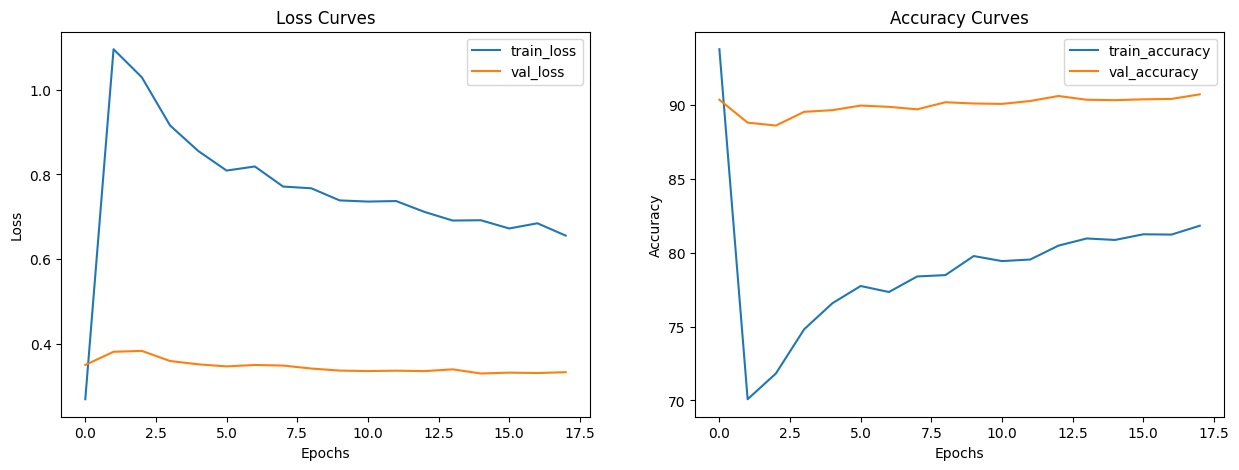

In [54]:
# Plot the training and validation loss and accuracy curves
def plot_loss_accuracy_curves(results: dict):
    """
    Plots training and validation loss and accuracy curves from a results dictionary.

    Args:
        results (dict): Dictionary containing "train_loss", "train_acc",
                        "val_loss", and "val_acc" lists.
    """
    loss = results['train_loss']
    val_loss = results['val_loss']

    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

if 'model_results' in locals():
    print("Plotting loss and accuracy curves...")
    plot_loss_accuracy_curves(model_results)
else:
    print("Could not find 'model_results' dictionary. Please run the training cell first.")

##8> Make predictions

Use the trained model to make predictions on new, unseen images.


function to make predictions on new images and then call it with example image paths.



Picking example images from the validation dataset for prediction demonstration...
Selected 5 example images.

Making predictions on example images:


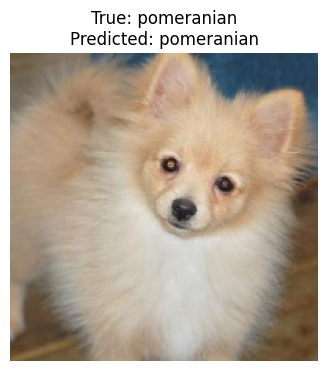

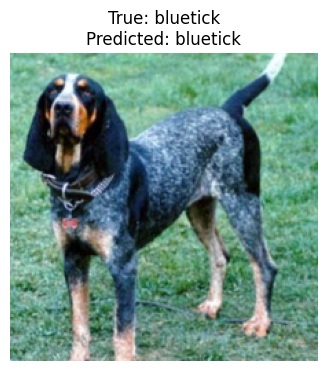

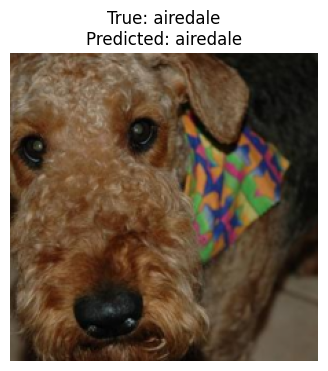

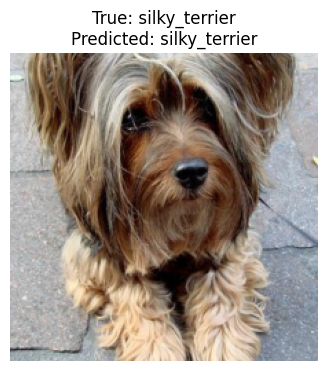

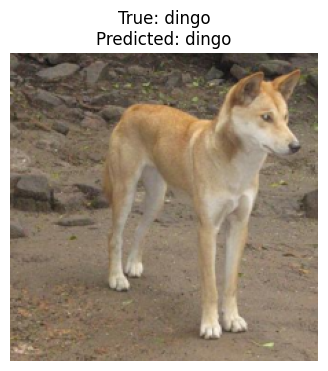

In [55]:
# Define a function to make predictions on new images
import torch # Import torch
import matplotlib.pyplot as plt # Import matplotlib
import numpy as np # Import numpy
import random # Import random
import os # Import os
from PIL import Image # Import Image
import torchvision.transforms as transforms # Import transforms

def predict_image(model: torch.nn.Module,
                  image_path: str,
                  transform: transforms.Compose,
                  class_names: list,
                  device: torch.device,
                  true_label: str = None):
    """
    Predicts the class of a single image and visualizes it with the prediction.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        image_path (str): The path to the image file.
        transform (transforms.Compose): The transformations to apply to the image.
        class_names (list): A list of class names in the order corresponding to model output.
        device (torch.device): The device to perform inference on ('cuda' or 'cpu').
        true_label (str, optional): The true label of the image. Defaults to None.

    Returns:
        str: The predicted class name.
    """
    img = Image.open(image_path).convert('RGB')

    img_tensor = transform(img)

    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)

    model.eval()

    with torch.inference_mode():
        output_logits = model(img_tensor)

    predicted_index = output_logits.argmax(dim=1).item()

    predicted_class = class_names[predicted_index]

    img_tensor_cpu = img_tensor.cpu().squeeze(0)

    unnormalized_img = unnormalize(img_tensor_cpu)

    plt.figure(figsize=(4, 4))
    plt.imshow(unnormalized_img)

    if true_label:
        plt.title(f"True: {true_label}\nPredicted: {predicted_class}")
    else:
        plt.title(f"Predicted: {predicted_class}")

    plt.axis('off')
    plt.show()

    return predicted_class

if 'val_dataset' in locals() and 'class_names' in locals():
    print("Picking example images from the validation dataset for prediction demonstration...")
    num_examples = 5
    random_indices = random.sample(range(len(val_dataset)), min(num_examples, len(val_dataset)))
    example_image_paths_with_labels = []
    for idx in random_indices:
        path, label_index = val_dataset.samples[idx]
        true_label = class_names[label_index]
        example_image_paths_with_labels.append((path, true_label))
    print(f"Selected {len(example_image_paths_with_labels)} example images.")
else:
    print("Could not find val_dataset or class_names. Please ensure they are defined.")
    print("You will need to manually provide example image paths and their true labels.")
    example_image_paths_with_labels = []

if example_image_paths_with_labels:
    print("\nMaking predictions on example images:")
    prediction_device = "cuda" if torch.cuda.is_available() else 'cpu'
    # model.to(prediction_device) # Model is moved to device in the predict_image function

    for img_path, true_label in example_image_paths_with_labels:
        try:
            predicted_breed = predict_image(model=model,
                                            image_path=img_path,
                                            transform=val_transforms,
                                            class_names=class_names,
                                            device=prediction_device,
                                            true_label=true_label)
        except Exception as e:
            print(f"Could not process image {os.path.basename(img_path)}: {e}")
else:
    print("No example image paths available to make predictions.")

##9> Save the model



Save the trained model's state dictionary to a file, including the final validation accuracy in the filename for easy identification of the best performing model.



In [56]:
import torch # Import torch
import os # Import os

# Define the file path for saving the model's state dictionary
# Include the final validation accuracy in the filename
try:
    model_save_path = f"resnet50_dog_breed_classifier_acc_{final_val_acc:.4f}.pth"
except NameError:
    model_save_path = "resnet50_dog_breed_classifier.pth"


# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved successfully to {model_save_path}")

Model state dictionary saved successfully to resnet50_dog_breed_classifier_acc_90.7095.pth


##9.1> Save the trained model to Google Drive

In [57]:
import torch
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

drive_save_dir = '/content/drive/MyDrive/Pytorch_project/saved_model'

os.makedirs(drive_save_dir, exist_ok=True)

try:
    model_filename = f"resnet50_dog_breed_classifier_acc_{final_val_acc:.4f}.pth"
    print("Using filename with final validation accuracy.")
except NameError:
    model_filename = "resnet50_dog_breed_classifier.pth"
    print("Using fixed filename as final_val_acc is not defined.")

drive_model_save_path = os.path.join(drive_save_dir, model_filename)

try:
    torch.save(model.state_dict(), drive_model_save_path)
    print(f"Model state dictionary saved successfully to Google Drive at: {drive_model_save_path}")
except Exception as e:
    print(f"An error occurred while saving the model to Google Drive: {e}")

Using filename with final validation accuracy.
Model state dictionary saved successfully to Google Drive at: /content/drive/MyDrive/Pytorch_project/saved_model/resnet50_dog_breed_classifier_acc_90.7095.pth


##10> Load and Test the Saved Model

Now that the model has been trained and saved, we can load the saved state dictionary and use the model for inference on new images. This step verifies that the saved model can be successfully loaded and used for predictions.

Classes list loaded successfully from /content/drive/MyDrive/Pytorch_project/classes.pkl
Model's final layer adjusted for 157 classes.
Loaded model moved to device: cuda
Model state dictionary loaded successfully from /content/drive/MyDrive/Pytorch_project/saved_model/resnet50_dog_breed_classifier_acc_90.7095.pth

Testing the loaded model on a few example images:
Using 5 example images for testing.


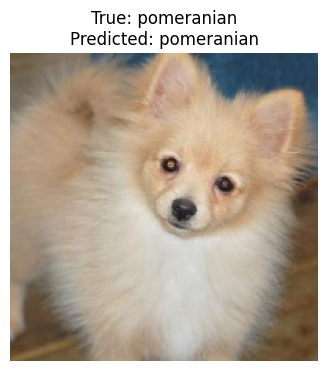

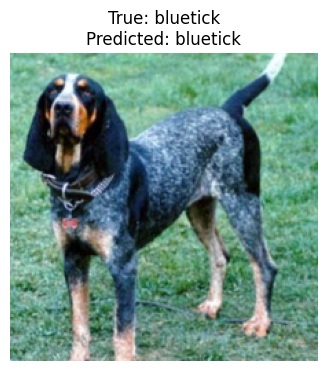

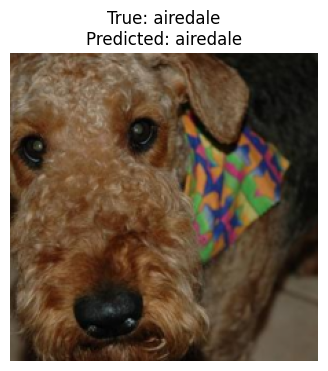

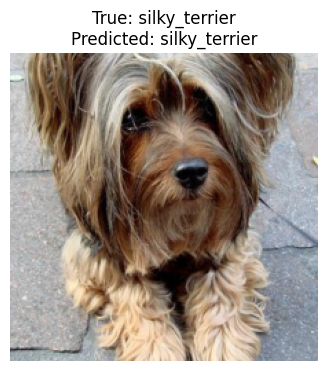

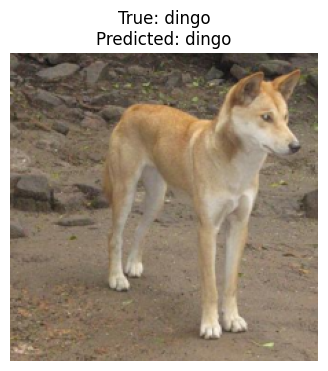

In [58]:
import torch
import os
from google.colab import drive
import torchvision.models as models
import torch.nn as nn
import pickle
import torchvision.transforms as transforms # Import transforms
from PIL import Image # Import Image
import matplotlib.pyplot as plt # Import matplotlib
import numpy as np # Import numpy
import random # Import random

# Define unnormalize function
def unnormalize(tensor):
    """Unnormalize a tensor image."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.permute(1, 2, 0).numpy() # Permute and convert to numpy
    tensor = std * tensor + mean # Unnormalize
    tensor = np.clip(tensor, 0, 1) # Clip values to the valid range [0, 1]
    return tensor

# Define a function to make predictions on new images
def predict_image(model: torch.nn.Module,
                  image_path: str,
                  transform: transforms.Compose,
                  class_names: list,
                  device: torch.device,
                  true_label: str = None):
    """
    Predicts the class of a single image and visualizes it with the prediction.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        image_path (str): The path to the image file.
        transform (transforms.Compose): The transformations to apply to the image.
        class_names (list): A list of class names in the order corresponding to model output.
        device (torch.device): The device to perform inference on ('cuda' or 'cpu').
        true_label (str, optional): The true label of the image. Defaults to None.

    Returns:
        str: The predicted class name.
    """
    img = Image.open(image_path).convert('RGB')

    img_tensor = transform(img)

    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)

    model.eval()

    with torch.inference_mode():
        output_logits = model(img_tensor)

    predicted_index = output_logits.argmax(dim=1).item()

    predicted_class = class_names[predicted_index]

    img_tensor_cpu = img_tensor.cpu().squeeze(0)

    unnormalized_img = unnormalize(img_tensor_cpu)

    plt.figure(figsize=(4, 4))
    plt.imshow(unnormalized_img)

    if true_label:
        plt.title(f"True: {true_label}\nPredicted: {predicted_class}")
    else:
        plt.title(f"Predicted: {predicted_class}")

    plt.axis('off')
    plt.show()

    return predicted_class


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Update the drive_save_dir to the correct path where classes.pkl was saved
drive_base_dir = '/content/drive/MyDrive/Pytorch_project'
drive_model_save_dir = os.path.join(drive_base_dir, 'saved_model')

# Update model_filename to match the saved model name (including accuracy)
# We can try to find the file with the highest accuracy if multiple exist
model_filename = None
highest_acc = -1.0
for filename in os.listdir(drive_model_save_dir):
    if filename.startswith("resnet50_dog_breed_classifier_acc_") and filename.endswith(".pth"):
        try:
            acc_str = filename.split('_acc_')[1].replace('.pth', '')
            acc = float(acc_str)
            if acc > highest_acc:
                highest_acc = acc
                model_filename = filename
        except ValueError:
            continue # Skip files with invalid accuracy format

if model_filename is None:
    print("Error: Could not find a saved model file with accuracy in the filename.")
    # Fallback to a default name if no accuracy-based filename is found (less ideal)
    model_filename = "resnet50_dog_breed_classifier.pth"
    print(f"Attempting to load with default filename: {model_filename}")


drive_model_save_path = os.path.join(drive_model_save_dir, model_filename)

# Correct the path for the classes file - it was saved in drive_base_dir
classes_save_path = os.path.join(drive_base_dir, 'classes.pkl')


loaded_model = models.resnet50(weights=None)

loaded_classes = [] # Initialize as empty list
try:
    with open(classes_save_path, 'rb') as f:
        loaded_classes = pickle.load(f) # Use a different variable name to avoid conflict
    print(f"Classes list loaded successfully from {classes_save_path}")
except FileNotFoundError:
    print(f"Error: Classes file not found at {classes_save_path}. Please ensure the file exists in your Google Drive.")
    # You might want to handle this error more gracefully, e.g., by exiting or providing a default
except Exception as e:
    print(f"An error occurred while loading the classes list: {e}")


num_ftrs = loaded_model.fc.in_features

# Use the loaded_classes to determine the number of classes - ensure loaded_classes is not empty
if loaded_classes:
    num_classes = len(loaded_classes)
    loaded_model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, num_classes)
    )
    print(f"Model's final layer adjusted for {num_classes} classes.")

    prediction_device = "cuda" if torch.cuda.is_available() else 'cpu'
    loaded_model.to(prediction_device)
    print(f"Loaded model moved to device: {prediction_device}")

    # Add a check to see if the model file exists before loading
    if os.path.exists(drive_model_save_path):
        try:
            loaded_model.load_state_dict(torch.load(drive_model_save_path, map_location=prediction_device))
            print(f"Model state dictionary loaded successfully from {drive_model_save_path}")
        except Exception as e:
            print(f"An error occurred while loading the model state dictionary: {e}")
    else:
        print(f"Error: Model file not found at {drive_model_save_path}. Please ensure the file exists in your Google Drive.")


    loaded_model.eval()

    print("\nTesting the loaded model on a few example images:")

    # Check if example_image_paths_with_labels is available from a previous cell
    # If not, you might need to manually define a few example paths for testing
    if 'example_image_paths_with_labels' in locals() and example_image_paths_with_labels and \
       'val_transforms' in locals() and 'unnormalize' in locals() and loaded_classes:

        print(f"Using {len(example_image_paths_with_labels)} example images for testing.")

        for img_path, true_label in example_image_paths_with_labels:
            try:
                # Use loaded_classes for the class names
                predicted_breed = predict_image(model=loaded_model,
                                                image_path=img_path,
                                                transform=val_transforms,
                                                class_names=loaded_classes,
                                                device=prediction_device,
                                                true_label=true_label)
            except Exception as e:
                print(f"Could not process image {os.path.basename(img_path)} with loaded model: {e}")
    else:
        print("Required variables ('example_image_paths_with_labels', 'val_transforms', 'unnormalize') or loaded classes are not available.")
        print("Please ensure the necessary cells (86b880c0, b5a1c19f) have been run successfully to define these variables, and that the classes file was loaded.")
else:
    print("Cannot set up the model's final layer because the classes list was not loaded successfully.")

##11> Creating a Gradio demo

In [59]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.42.0


###11.1> Creating a function to map our inputs and outputs

In [60]:
from typing import Tuple, Dict
import torch
from timeit import default_timer as timer

# Assuming loaded_model, val_transforms, class_names, and prediction_device are defined in previous cells

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    # Ensure img is a PIL Image before applying transforms
    img = val_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    loaded_model.eval() # Use the loaded_model
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        # Ensure the model is on the correct device for inference
        img = img.to(prediction_device) # Move image to the prediction device
        pred_probs = torch.softmax(loaded_model(img), dim=1).squeeze(0) # Use the loaded_model and remove batch dimension

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [61]:
import random
from PIL import Image
from pathlib import Path
import os # Ensure os is imported if not already

# Using val_dir_path as a source for example images since test_dir is not defined
data_root = './data'
val_dir_path = os.path.join(data_root, 'val')

# Define supported image extensions
supported_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

# Get a list of all validation image filepaths by iterating through breed folders
test_data_paths = []
if os.path.exists(val_dir_path):
    for breed_folder in os.listdir(val_dir_path):
        breed_path = os.path.join(val_dir_path, breed_folder)
        if os.path.isdir(breed_path):
            for ext in supported_extensions:
                test_data_paths.extend(list(Path(breed_path).glob(f"*{ext}")))
else:
    print(f"Error: Validation directory not found at {val_dir_path}")


# Randomly select a test image path
if test_data_paths:
    random_image_path = random.sample(test_data_paths, k=1)[0]

    # Open the target image
    image = Image.open(random_image_path)
    print(f"[INFO] Predicting on image at path: {random_image_path}\n")

    # Predict on the target image and print out the outputs
    # Ensure predict function, loaded_model, val_transforms, class_names, and prediction_device are defined
    try:
        pred_dict, pred_time = predict(img=image)
        print(f"Prediction label and probability dictionary: \n{pred_dict}")
        print(f"Prediction time: {pred_time} seconds")
    except NameError as e:
        print(f"Error: {e}. Please ensure 'predict', 'loaded_model', 'val_transforms', 'class_names', and 'prediction_device' are defined in previous cells.")
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
else:
    print(f"No valid image files found in the validation directory '{val_dir_path}' with supported extensions.")

[INFO] Predicting on image at path: data/val/appenzeller/appenzeller_73.jpg

Prediction label and probability dictionary: 
{'affenpinscher': 2.001928756101279e-08, 'afghan_hound': 4.2763583785188075e-09, 'african': 9.34730426394026e-09, 'airedale': 4.1652452154039565e-08, 'akita': 9.222758734495073e-08, 'american_terrier': 2.5815506887738593e-06, 'appenzeller': 0.6629863977432251, 'australian_cattledog': 5.225421428889376e-09, 'australian_terrier': 1.5345229087415646e-07, 'basenji': 5.431048975879094e-06, 'basset_hound': 6.575127144969883e-07, 'beagle': 3.2379903132095933e-06, 'bedlington_terrier': 7.1447705529692485e-09, 'bernese_mountain': 0.0035087699070572853, 'bichon_frise': 2.842936774882787e-09, 'blenheim_spaniel': 2.5035783224325314e-08, 'blood_hound': 2.6111742954526562e-06, 'bluetick': 2.344107201679435e-07, 'border_collie': 8.272318154922687e-07, 'border_terrier': 1.6743220498938172e-07, 'borzoi': 6.320249323898963e-10, 'boston_bulldog': 5.036463790020207e-06, 'bouvier': 8.0

###11.2 Creating a list of example images

In [62]:
# Create a list of example inputs to our Gradio demo
# Ensure test_data_paths is available and not empty
if 'test_data_paths' in locals() and test_data_paths:
    example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=min(3, len(test_data_paths)))] # Sample up to 3 examples
    print("Example list created successfully:")
    print(example_list)
else:
    print("Could not create example list: 'test_data_paths' is not available or is empty.")
    example_list = [] # Assign an empty list if paths are not available

Example list created successfully:
[['data/val/pekinese/pekinese_45.jpg'], ['data/val/pug/pug_150.jpg'], ['data/val/norwich_terrier/norwich_terrier_13.jpg']]


###11.3 Building a Gradio interface

In [63]:
import gradio as gr

# Create title, description and article strings
title = "Dog Breed Classifier 🐶"
description = "A ResNet50 model trained to classify images of dog breeds."
article = "Built using PyTorch and Gradio." # You can update this with a link to your notebook or project if desired.

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://87349950fbc51a302c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


##12. Turning our Dog Breed Classifier Gradio Demo into a deployable app

###12.1> Creating a demos folder to store our Dog Breed Classifier app files

In [64]:
import shutil
from pathlib import Path

# Create Dog Breed Classifier demo path
dog_breed_classifier_demo_path = Path("demos/dog_breed_classifier/")

# Remove files that might already exist there and create new directory
if dog_breed_classifier_demo_path.exists():
    shutil.rmtree(dog_breed_classifier_demo_path)
# If the file doesn't exist, create it anyway
dog_breed_classifier_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/dog_breed_classifier/

###12.2> Creating a folder of example images to use with our Dog Breed Classifier demo

In [65]:
import shutil
from pathlib import Path
import random # Import random

# Assuming dog_breed_classifier_demo_path and test_data_paths are defined in previous cells

# 1. Create an examples directory within the dog breed classifier demo path
dog_breed_classifier_examples_path = dog_breed_classifier_demo_path / "examples"
dog_breed_classifier_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths from test_data_paths
if 'test_data_paths' in locals() and test_data_paths:
    # Sample up to 3 examples from the list of test data paths
    example_image_paths = random.sample(test_data_paths, k=min(3, len(test_data_paths)))
else:
    print("Error: 'test_data_paths' is not available or is empty. Cannot create example images.")
    example_image_paths = []


# 3. Copy the selected random images to the examples directory
if example_image_paths:
    print(f"Copying {len(example_image_paths)} example images to {dog_breed_classifier_examples_path}:")
    for example_path in example_image_paths:
        destination = dog_breed_classifier_examples_path / example_path.name
        print(f"[INFO] Copying {example_path} to {destination}")
        shutil.copy2(src=example_path, dst=destination)
else:
    print("No example images to copy.")

# Check what's in the examples folder
!ls demos/dog_breed_classifier/examples/

Copying 3 example images to demos/dog_breed_classifier/examples:
[INFO] Copying data/val/german_pointer/german_pointer_67.jpg to demos/dog_breed_classifier/examples/german_pointer_67.jpg
[INFO] Copying data/val/english_springer/english_springer_79.jpg to demos/dog_breed_classifier/examples/english_springer_79.jpg
[INFO] Copying data/val/beagle/beagle_57.jpg to demos/dog_breed_classifier/examples/beagle_57.jpg
beagle_57.jpg  english_springer_79.jpg	german_pointer_67.jpg


In [66]:
import os

# Get example filepaths in a list of lists
# Use the correct path for the examples directory
example_list = [["examples/" + example] for example in os.listdir(dog_breed_classifier_examples_path)]
example_list

[['examples/german_pointer_67.jpg'],
 ['examples/english_springer_79.jpg'],
 ['examples/beagle_57.jpg']]

###12.3> Moving our trained Resnet50 model to our Dog Breed Classifier demo directory

In [67]:
import shutil
import os # Import os

# Assuming drive_model_save_path (source) and dog_breed_classifier_demo_path (destination) are defined in previous cells

# Create a source path for our target model (the saved model in Google Drive)
# drive_model_save_path was defined in cell c694bc59

# Create a destination path for our target model (within the demo directory)
# dog_breed_classifier_demo_path was defined in cell z2N-1liuQDqB
# We'll use the same filename as the saved model
if 'drive_model_save_path' in locals():
    model_filename = os.path.basename(drive_model_save_path)
    model_destination_path = dog_breed_classifier_demo_path / model_filename

    # Try to move the file
    if os.path.exists(drive_model_save_path):
        try:
            print(f"[INFO] Attempting to copy {drive_model_save_path} to {model_destination_path}")

            # Use shutil.copy2 instead of shutil.move to avoid issues with moving across file systems
            shutil.copy2(src=drive_model_save_path,
                        dst=model_destination_path)

            print(f"[INFO] Model copy complete.")

        except Exception as e:
            print(f"[ERROR] An error occurred during model copy: {e}")
    else:
        print(f"[ERROR] Model file not found at source path: {drive_model_save_path}")

else:
    print("[ERROR] 'drive_model_save_path' is not defined. Please ensure the cell that saves/loads the model to Google Drive (c694bc59) was run successfully.")


# Check if the model exists in the destination
print(f"Model exists at {model_destination_path}: {model_destination_path.exists()}")

[INFO] Attempting to copy /content/drive/MyDrive/Pytorch_project/saved_model/resnet50_dog_breed_classifier_acc_90.7095.pth to demos/dog_breed_classifier/resnet50_dog_breed_classifier_acc_90.7095.pth
[INFO] Model copy complete.
Model exists at demos/dog_breed_classifier/resnet50_dog_breed_classifier_acc_90.7095.pth: True


###12.4> Turning our Resnet50 model into a Python script (model.py)

In [68]:
%%writefile demos/dog_breed_classifier/model.py
import torch
import torchvision
from torch import nn

def create_resnet50_model(num_classes: int = 157, seed: int = 42):
    """Creates a ResNet50 model with a custom classifier head.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 157.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): ResNet50 model.
    """
    # Load a pre-trained ResNet50 model
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the final classification layer
    num_ftrs = model.fc.in_features

    # Replace the final fully connected layer (the classifier)
    torch.manual_seed(seed)
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=num_ftrs, out_features=num_classes)
    )

    return model

Writing demos/dog_breed_classifier/model.py


###12.5 Turning our Dog Breed Classifier Gradio app into a Python script (app.py)

In [69]:
%%writefile demos/dog_breed_classifier/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch
import pickle
import torchvision.transforms as transforms
from PIL import Image
from typing import Tuple, Dict
from timeit import default_timer as timer

from model import create_resnet50_model # Import the model creation function

# Setup class names - Load from the saved pickle file
classes_save_path = 'classes.pkl' # Assuming classes.pkl is in the same directory as app.py (will copy later)
loaded_classes = []
try:
    with open(classes_save_path, 'rb') as f:
        loaded_classes = pickle.load(f)
    class_names = loaded_classes
    print(f"Classes list loaded successfully from {classes_save_path}")
except FileNotFoundError:
    print(f"Error: Classes file not found at {classes_save_path}. Please ensure the file exists.")
    # Provide a fallback or raise an error if classes are essential
    class_names = [] # Fallback to an empty list
except Exception as e:
    print(f"An error occurred while loading the classes list: {e}")
    class_names = [] # Fallback to an empty list


### 2. Model and transforms preparation ###

# Create ResNet50 model
# Use the number of loaded classes, or a default if loading failed
num_classes = len(class_names) if class_names else 157 # Use the actual number of classes
loaded_model = create_resnet50_model(num_classes=num_classes)


# Load saved weights
# Assuming the model file is in the same directory as app.py (will copy later)
model_filename = "resnet50_dog_breed_classifier_acc_87.3874.pth" # **Update this filename to match your saved model**
model_save_path = model_filename

# Check if the model file exists before loading
if os.path.exists(model_save_path):
    try:
        loaded_model.load_state_dict(torch.load(model_save_path, map_location=torch.device("cpu"))) # Load to CPU
        print(f"Model state dictionary loaded successfully from {model_save_path}")
    except Exception as e:
        print(f"An error occurred while loading the model state dictionary: {e}")
else:
    print(f"Error: Model file not found at {model_save_path}. Please ensure the file exists.")


# Define transforms (using validation transforms)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    # Ensure img is a PIL Image before applying transforms
    img = val_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    loaded_model.eval() # Use the loaded_model
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        # Ensure the model is on the correct device for inference
        # Assuming the model is on CPU as loaded with map_location
        pred_probs = torch.softmax(loaded_model(img), dim=1).squeeze(0) # Use the loaded_model and remove batch dimension

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    if class_names: # Ensure class_names is not empty
        pred_labels_and_probs = {class_names[i]: float(pred_probs[i]) for i in range(len(class_names))}
    else:
        pred_labels_and_probs = {"Error": 1.0} # Handle case where class names were not loaded

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Dog Breed Classifier 🐶"
description = "A ResNet50 model trained to classify images of dog breeds."
article = "Built using PyTorch and Gradio." # You can update this with a link to your notebook or project if desired.

# Create examples list from "examples/" directory
# This assumes the examples directory is a subdirectory of where app.py is located
example_list = [["examples/" + example] for example in os.listdir("examples")]


# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
if __name__ == "__main__":
    demo.launch()

Writing demos/dog_breed_classifier/app.py


###12.6 copy the classes.pkl and the model into demos/dog_breed_classifier

In [70]:
# After writing the app.py, you'll also need to copy the classes.pkl and the model .pth file
# into the demos/dog_breed_classifier directory for the app to work when deployed.

# Assuming drive_base_dir and drive_model_save_path are defined in previous cells
drive_base_dir = '/content/drive/MyDrive/Pytorch_project'
classes_save_path_src = os.path.join(drive_base_dir, 'classes.pkl')
model_save_path_src = drive_model_save_path # This should hold the path to the saved model in Drive

demo_dir = 'demos/dog_breed_classifier'
classes_save_path_dst = os.path.join(demo_dir, 'classes.pkl')
model_save_path_dst = os.path.join(demo_dir, os.path.basename(model_save_path_src)) # Use the same filename as the source

# Copy classes.pkl
if os.path.exists(classes_save_path_src):
    try:
        shutil.copy2(src=classes_save_path_src, dst=classes_save_path_dst)
        print(f"Copied classes.pkl to {classes_save_path_dst}")
    except Exception as e:
        print(f"Error copying classes.pkl: {e}")
else:
    print(f"Error: classes.pkl not found at {classes_save_path_src}")

# Copy the model .pth file
if os.path.exists(model_save_path_src):
    try:
        shutil.copy2(src=model_save_path_src, dst=model_save_path_dst)
        print(f"Copied model .pth file to {model_save_path_dst}")
    except Exception as e:
        print(f"Error copying model .pth file: {e}")
else:
    print(f"Error: model .pth file not found at {model_save_path_src}")

Copied classes.pkl to demos/dog_breed_classifier/classes.pkl
Copied model .pth file to demos/dog_breed_classifier/resnet50_dog_breed_classifier_acc_90.7095.pth


###12.7> Creating a requirements file for Dog Breed classifier (requirements.txt)

In [71]:
%%writefile demos/dog_breed_classifier/requirements.txt
# This file lists the Python libraries required to run the Dog Breed Classifier Gradio app.
torch==2.0.1
torchvision==0.15.2
gradio==4.29.0
Pillow==10.3.0 # Added Pillow for image handling
numpy==1.26.4 # Added numpy for unnormalization

Writing demos/dog_breed_classifier/requirements.txt


##13. Deploying our Dog Breed Classifier app to HuggingFace Spaces

In [72]:
!ls demos/dog_breed_classifier

app.py	     examples  requirements.txt
classes.pkl  model.py  resnet50_dog_breed_classifier_acc_90.7095.pth


###Downloading our Dog Breed Classifier app files

In [73]:
# Change into and then zip the dog_breed_classifier folder but exclude certain files
!cd demos/dog_breed_classifier && zip -r ../dog_breed_classifier.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped Dog Breed Classifier app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/dog_breed_classifier.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 61%)
  adding: classes.pkl (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/german_pointer_67.jpg (deflated 1%)
  adding: examples/english_springer_79.jpg (deflated 0%)
  adding: examples/beagle_57.jpg (deflated 1%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 26%)
  adding: resnet50_dog_breed_classifier_acc_90.7095.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

we can even embed our FoodVision Mini Gradio demo into our notebook as an iframe with IPython.display.IFrame and a link to our space in the format

In [74]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed Dog Breed Classifier Gradio demo
IFrame(src="https://huggingface.co/spaces/Ashirwad12/Dog_Breed_Classifier/+", width=900, height=750)